## Is it a penguin?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-cloud-aiplatform 0.6.0a1 requires google-cloud-storage<2.0.0dev,>=1.26.0, but you have google-cloud-storage 2.1.0 which is incompatible.
gcsfs 2022.2.0 requires fsspec==2022.02.0, but you have fsspec 2022.3.0 which is incompatible.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.1 which is incompatible.
en-core-web-lg 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.1 which is incompatible.
apache-beam 2.37.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
apache-beam 2.37.0 requires pyarrow<7.0.0,>=0.15.1, but you have pyarrow 7.0.0 which is incompatibl

## Step 1: Download images of penguin and birds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a penguin photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('penguin photos', max_images=1)
urls[0]

Searching for 'penguin photos'


'http://www.chimuadventures.com/blog/wp-content/uploads/2016/04/Rockhopper_Penguins_shutterstock_140644825.jpg'

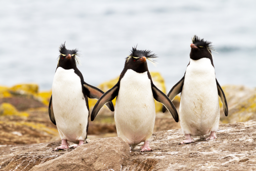

In [5]:
from fastdownload import download_url
dest = 'penguin.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "bird photos":

Searching for 'bird photos'


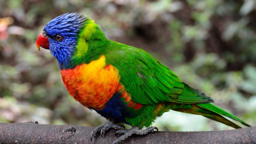

In [6]:
download_url(search_images('bird photos', max_images=1)[0], 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "penguin" and "bird" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'penguin','bird'
path = Path('penguin_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} flying photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} eating photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sitting photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} fighting photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} killing photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'penguin photo'
Searching for 'penguin flying photo'
Searching for 'penguin eating photo'
Searching for 'penguin sitting photo'
Searching for 'penguin fighting photo'
Searching for 'penguin killing photo'
Searching for 'bird photo'
Searching for 'bird flying photo'
Searching for 'bird eating photo'
Searching for 'bird sitting photo'
Searching for 'bird fighting photo'
Searching for 'bird killing photo'


## Step 2: Train our model

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

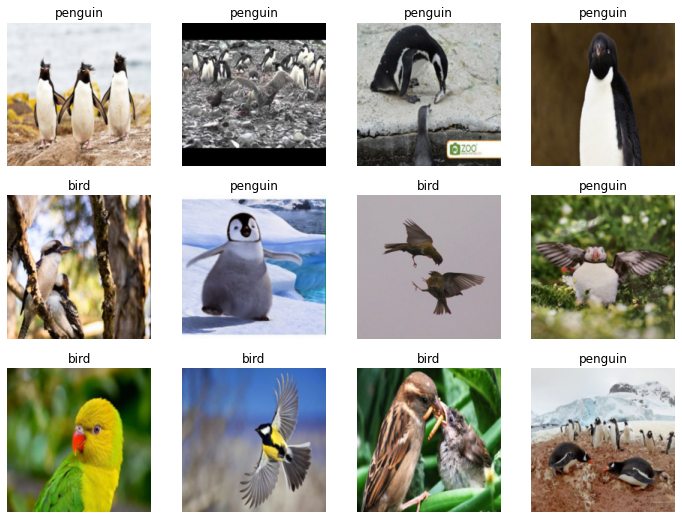

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.094288,0.108504,0.044776,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.234656,0.135382,0.059701,00:29
1,0.163780,0.173680,0.074627,00:29
2,0.127567,0.166677,0.044776,00:29


## Step 3: Using the model 

Let's see what our model thinks about that penguin we downloaded at the start:

In [11]:
is_penguin,_,probs = learn.predict(('penguin.jpg'))
print(f"This is a: {is_penguin}.")
print(f"Probability it's a penguin: {probs[0]:.4f}")

This is a: penguin.
Probability it's a penguin: 0.0001
